In [13]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *

In [14]:
image_size = (256, 256)
batch = 32

train = keras.preprocessing.image_dataset_from_directory(
    './data/',
    validation_split=.2,
    subset='training',
    seed=42,
    image_size=image_size,
    batch_size=batch,
    label_mode='categorical'
)

Found 552 files belonging to 6 classes.
Using 442 files for training.


In [15]:
validation = keras.preprocessing.image_dataset_from_directory(
    './data/',
    validation_split=.2,
    subset='validation',
    seed=42,
    image_size=image_size,
    batch_size=batch,
    label_mode='categorical'
)

Found 552 files belonging to 6 classes.
Using 110 files for validation.


In [16]:
def display_samples(dataset, n_samples, classes_name):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(n_samples):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(classes_name[np.argmax(labels[i])])
            plt.axis("off")

(256, 256, 3)


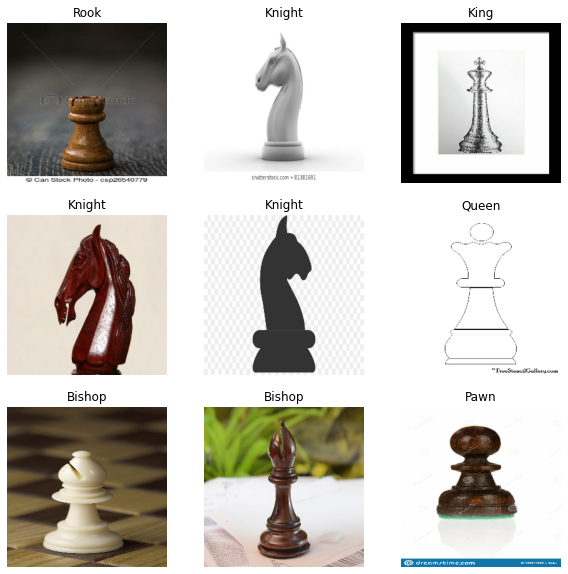

In [17]:
display_samples(train, 9, train.class_names)
for images, labels in train.take(1):
        for i in range(1):
            print(images[i].shape)

In [18]:
class_names = train.class_names
labels = np.array([])
for _, label in train:
    labels = np.concatenate((labels, np.argmax(label, axis=-1)))
_, counts = np.unique(labels, return_counts=True)

In [19]:
total = counts.sum()
for i in range(len(counts)):
    print(f'{class_names[i]}: {counts[i]}({counts[i] / total:.2f}%)')

Bishop: 71(0.16%)
King: 62(0.14%)
Knight: 85(0.19%)
Pawn: 83(0.19%)
Queen: 64(0.14%)
Rook: 77(0.17%)


In [20]:
input_shape = (image_size[0], image_size[1], 3)
reg = keras.regularizers.l2(0.0005)

model = keras.Sequential()
model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=image_size + (3,), kernel_regularizer=reg))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization(axis=3))
# model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same", activation="relu", kernel_regularizer=reg))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization(axis=3))
# model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same", activation="relu", kernel_regularizer=reg))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization(axis=3))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(train.class_names), activation='softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 128)     

In [21]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

epochs = 40
model.fit(
    train,
    epochs=epochs,
    validation_data=validation
)

Epoch 1/40
14/14 [==============================] - 29s 2s/step - loss: 2.5082 - accuracy: 0.1652 - val_loss: 69.0941 - val_accuracy: 0.2000
Epoch 2/40
14/14 [==============================] - 30s 2s/step - loss: 2.1113 - accuracy: 0.1968 - val_loss: 3.9034 - val_accuracy: 0.2364
Epoch 3/40
14/14 [==============================] - 32s 2s/step - loss: 1.9694 - accuracy: 0.2828 - val_loss: 4.1971 - val_accuracy: 0.1091
Epoch 4/40
14/14 [==============================] - 28s 2s/step - loss: 1.7482 - accuracy: 0.3756 - val_loss: 11.4368 - val_accuracy: 0.2182
Epoch 5/40
14/14 [==============================] - 28s 2s/step - loss: 1.6802 - accuracy: 0.3756 - val_loss: 3.2412 - val_accuracy: 0.1818
Epoch 6/40
 9/14 [==================>...........] - ETA: 9s - loss: 1.4270 - accuracy: 0.4583 

KeyboardInterrupt: 

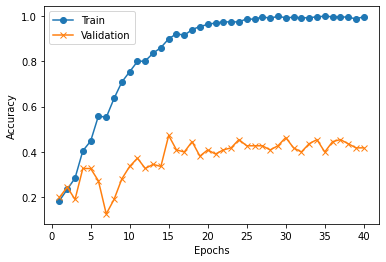

In [ ]:
epochs_range = [i+1 for i in range(epochs)]
plt.plot(epochs_range, model.history.history['accuracy'], '-o', label='Train')
plt.plot(epochs_range, model.history.history['val_accuracy'], '-x',label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend();

In [ ]:
y_pred = np.argmax(model.predict(validation), axis=-1)

predictions = np.array([])
labels =  np.array([])
for x, y in validation:
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

1/1 [==============================] - 0s 185ms/step


<AxesSubplot:>

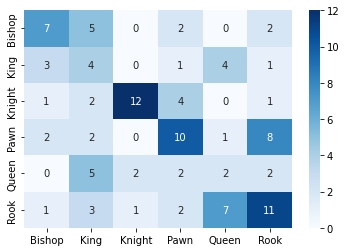

In [ ]:
conf = tf.math.confusion_matrix(labels=labels, predictions=predictions)
sns.heatmap(conf, annot=True, cmap='Blues', yticklabels=class_names, xticklabels=class_names)